# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse', 'difference'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae', 'difference'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score', 'difference'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs', 'difference'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
def transform_y (y_train,y_test):
  y_target = y_train.to_numpy()
  y_tr_test = y_test.to_numpy()

  y_data = y_target.reshape(len(y_target), 1)
  y_data_test = y_tr_test.reshape(len(y_tr_test), 1)

  # QuantileTransformer to make bimodel to uniform
  quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

  y_trans = quant_trans.fit_transform(y_data)
  y_trans_test = quant_trans.transform(y_data_test)
  return y_target, y_trans,  y_tr_test, y_trans_test

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

In [ ]:
def transform_scale_RH (RH_transformer, df, scaler):
  X_train_o, X_test_o, y_train, y_test = reset_t_t_split(df, KNNImputer(n_neighbors=2))
  #train and test numpy array with transfromed RH col
 
  RH_train, RH_test = transform(RH_transformer,X_train_o, X_test_o, 'final_transform_box_cox', 'RH')

  RH_train_col = RH_train[:,[1]]
  X_train_mod = X_train_o[:,[0,1,2]]
  X_train_final_RH = np.append(X_train_mod, RH_train_col, axis=1)


  RH_test_col = RH_test[:,[1]]
  X_test_mod = X_test_o[:,[0,1,2]]
  X_test_final_RH = np.append(X_test_mod, RH_test_col, axis=1)

  X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig = scale(scaler, X_train_final_RH, X_test_final_RH , y_train, y_test)
  return X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")
#train
    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)
#test
    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)
#difference
    diff_r2 = r2_score_train - r2_score_test
    diff_evs = evs_train - evs_test
    diff_mae = mae_test - mae_train
    diff_mse = mse_test - mse_train

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3), round( diff_r2*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3), round( diff_evs*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

In [ ]:
#define model architecture and complie model
def define_model (name, opt, n_layers, unt, input_vec_len):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = unt, activation = 'relu', input_shape = (input_vec_len,)))
  for n in range(1, n_layers):
     model.add(tf.keras.layers.Dense(units = unt, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1))
  model.compile(optimizer = opt, loss="mse",  metrics = ['mae'])
  return model

In [ ]:
#evaluate model
def evaluate_model_pipe (name, pipe, pat,  n_layers, unt, batch, opt, ep,  n_folds = 5):
  histories = list()
  early_stopping_monitor = EarlyStopping(patience=pat)
  checkpointer = ModelCheckpoint(
      filepath = f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_{name}.hdf5',
      verbose = 1,
      save_best_only = True
  )
  input_vec_len = X_train.shape[1]
  name = define_model(name, opt, n_layers, unt, input_vec_len)
  history = name.fit(X_train, y_train, epochs = ep, batch_size = batch, verbose = 0, validation_data=(X_test, y_test), callbacks= [early_stopping_monitor, checkpointer])
  histories.append(history)
  _y_pred_test = name.predict(X_test).reshape(-1,1)
  y_pred_test = pipe.inverse_transform(_y_pred_test)
  y_pred_train = pipe.inverse_transform(name.predict(X_train).reshape(-1,1))
  return histories, y_pred_test, y_pred_train

In [ ]:
#plot diagnostic learning curves
def show_plots (histories, name):
  f = plt.figure(figsize=(30,4))
  st = f.suptitle(name, fontsize="x-large")

  plt.subplot(1,2,1)
  # plot loss during training
  plt.title('Loss (Mean Squared Error)')
  plt.plot(histories[0].history['loss'], label='train mse')
  plt.plot(histories[0].history['val_loss'], label='test mse')
  ax = plt.gca()
  ax.get_yaxis().set_visible(False)
  plt.legend()

  plt.subplot (1,2,2)
  plt.title('Mean Absolute Error')
  plt.plot(histories[0].history['mae'], label='train mae')
  plt.plot(histories[0].history['val_mae'], label='test mae')
  axes = plt.gca()
  axes.get_yaxis().set_visible(False)
  plt.legend()

  plt.savefig(f"{name} model results.pdf") 
  plt.show()

In [ ]:
#count results and save to dataframe
def results(name,  y_pred_test,  y_pred_train):
  r2_score_train = round(r2_score(y_train_orig, y_pred_train)*100,3)
  evs_train = round(explained_variance_score(y_train_orig, y_pred_train)*100,3)
  mae_train = mean_absolute_error(y_train_orig, y_pred_train)
  mse_train = mean_squared_error(y_train_orig, y_pred_train)

  r2_score_test = round(r2_score(y_test_orig, y_pred_test)*100,3)
  evs_test = round(explained_variance_score(y_test_orig, y_pred_test)*100,3)
  mae_test = mean_absolute_error(y_test_orig, y_pred_test)
  mse_test = mean_squared_error(y_test_orig, y_pred_test)

  #difference
  diff_r2 = r2_score_train - r2_score_test
  diff_evs = evs_train - evs_test
  diff_mae = mae_test - mae_train
  diff_mse = mse_test - mse_train

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, round(diff_r2,3)]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, round( diff_evs,3)]
  results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
  results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

  results = pd.DataFrame(columns = ['type', 'mean_squared_error', 'mean_absolute_error',  'r2_score', 'e_v_score'])
  results.loc[0] = [f"train:_{name}", round( mse_train,3),round( mae_train,3), r2_score_train ,evs_train]
  results.loc[1] = [f"test:_{name}",  round( mse_test,3) , round( mae_test,3) , r2_score_test ,evs_test]
  results.loc[2] = [f"{name}", round( diff_mse,3) , round( diff_mae,3) , round( diff_r2,3) ,round( diff_evs,3)]

  print(results)
  return results

In [ ]:
# complete run from model training, evaluation, vizualization and resalts saving
def complete_run (name, pipe,ep = 450, pat = 50, opt = 'adam', n_layers = 1, unt = 6, batch = 256):

  histories, y_pred_test, y_pred_train = evaluate_model_pipe (name, pipe, pat, n_layers, unt, batch, opt, ep,  n_folds = 5)

  show_plots(histories, name)
  
  data_res = results(name,  y_pred_test,  y_pred_train)
  data_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results/{name}_results.csv', index=False) 

In [ ]:
#upload results from path and save to main results df
def upload_save_results(df):
  name = df.loc[2]['type']
  r2_score_train = df.loc[0]['r2_score']
  evs_train = df.loc[0]['e_v_score']
  mae_train = df.loc[0]['mean_absolute_error']
  mse_train = df.loc[0]['mean_squared_error']

  r2_score_test = df.loc[1]['r2_score']
  evs_test = df.loc[1]['e_v_score']
  mae_test = df.loc[1]['mean_absolute_error']
  mse_test = df.loc[1]['mean_squared_error']

    #difference
  diff_r2 = df.loc[2]['r2_score']
  diff_evs = df.loc[2]['e_v_score']
  diff_mae = df.loc[2]['mean_absolute_error']
  diff_mse = df.loc[2]['mean_squared_error']

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, diff_r2]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, diff_evs]
  results_mae.loc[len(results_mae.index)] = [name, mae_train, mae_test, diff_mae]
  results_mse.loc[len(results_mse.index)] = [name, mse_train, mse_test, diff_mse]

In [ ]:
#update results from saved files
def update_results(isFinal = False):
  mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results'
  if isFinal:
    mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results_final'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for file in onlyfiles:
    df = pd.read_csv(f"{mypath}/{file}")
    upload_save_results(df)

In [ ]:
#save model as json file
def save_model_as_json(model,name):
  model_json = model.to_json()
  with open(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-classifier-model_{name}.json', 'w') as json_file:
    json_file.write(model_json)

### -show results

In [ ]:
def percent_graph (df, test):
  N = len(df.iloc[:10])
  new_df = df.sort_values(test, ascending=True).iloc[:10]
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[test].values.tolist(), color = 'orange')
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[test].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
      ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'white', fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def failure_graph (df, train, test):
  N = len(df)
  new_df = df.sort_values(test, ascending=False)
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[train].values.tolist())
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[train].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
    ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'orange',fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def show_results(isGraph = True):
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    if isGraph:
      failure_graph(results_mse, 'train_mse', 'test_mse')
      failure_graph(results_mae, 'train_mae', 'test_mae')
      percent_graph (results_evs, 'test_evs')
      percent_graph (results_r2score, 'test_r2score')
    
    

# 3.5 Final version check

Let`s let models with selected hyper parameters run several time and check results

## model 1


Epoch 1: val_loss improved from inf to 0.09817, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_0_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 2: val_loss improved from 0.09817 to 0.03894, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_0_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 3: val_loss improved from 0.03894 to 0.02821, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_0_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 4: val_loss improved from 0.02821 to 0.02392, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_0_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 5: val_loss improved from 0.02392 to 0.02354, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/wei

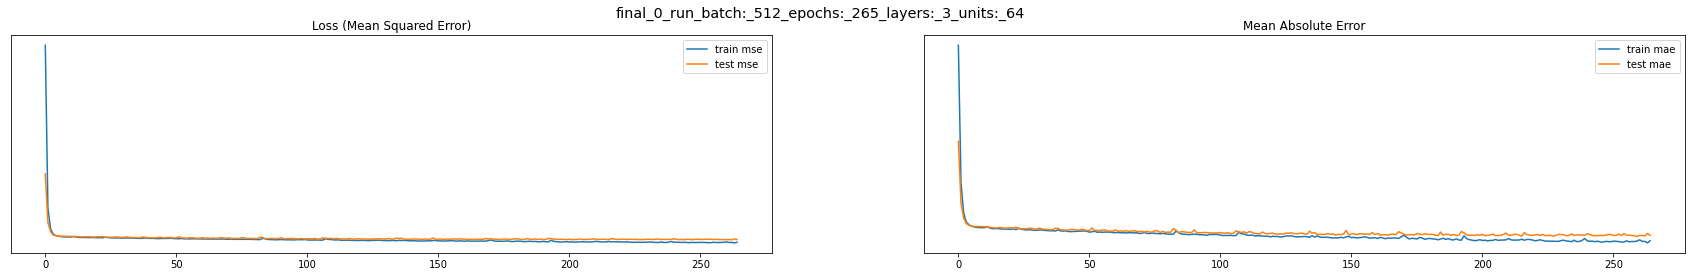

                                                type  mean_squared_error  \
0  train:_final_0_run_batch:_512_epochs:_265_laye...              11.396   
1  test:_final_0_run_batch:_512_epochs:_265_layer...              14.807   
2  final_0_run_batch:_512_epochs:_265_layers:_3_u...               3.411   

   mean_absolute_error  r2_score  e_v_score  
0                2.498    96.076     96.079  
1                2.851    94.949     94.951  
2                0.354     1.127      1.128  

Epoch 1: val_loss improved from inf to 0.08061, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_1_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 2: val_loss improved from 0.08061 to 0.03737, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_1_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 3: val_loss improved from 0.03737 to 0.02788, saving model to /content

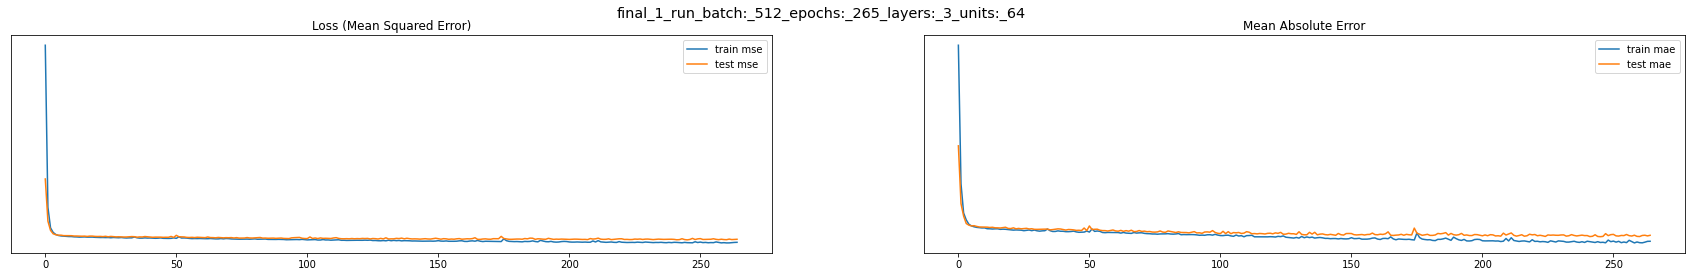

                                                type  mean_squared_error  \
0  train:_final_1_run_batch:_512_epochs:_265_laye...              12.232   
1  test:_final_1_run_batch:_512_epochs:_265_layer...              15.096   
2  final_1_run_batch:_512_epochs:_265_layers:_3_u...               2.864   

   mean_absolute_error  r2_score  e_v_score  
0                2.596    95.788     95.902  
1                2.906    94.850     94.965  
2                0.310     0.938      0.937  

Epoch 1: val_loss improved from inf to 0.05444, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_2_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 2: val_loss improved from 0.05444 to 0.03397, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_2_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 3: val_loss improved from 0.03397 to 0.02618, saving model to /content

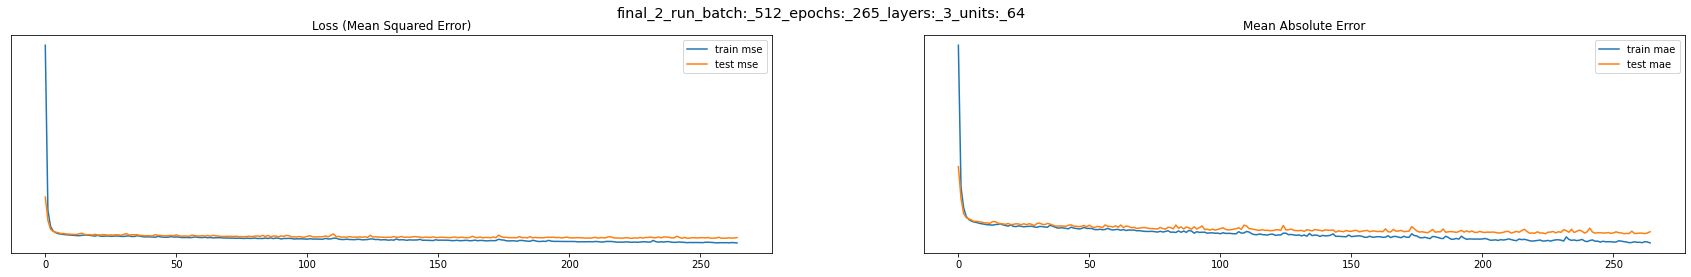

                                                type  mean_squared_error  \
0  train:_final_2_run_batch:_512_epochs:_265_laye...              11.479   
1  test:_final_2_run_batch:_512_epochs:_265_layer...              15.104   
2  final_2_run_batch:_512_epochs:_265_layers:_3_u...               3.625   

   mean_absolute_error  r2_score  e_v_score  
0                2.504    96.048     96.164  
1                2.880    94.848     94.973  
2                0.375     1.200      1.191  

Epoch 1: val_loss improved from inf to 0.08684, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_3_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 2: val_loss improved from 0.08684 to 0.03635, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_3_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 3: val_loss improved from 0.03635 to 0.02634, saving model to /content

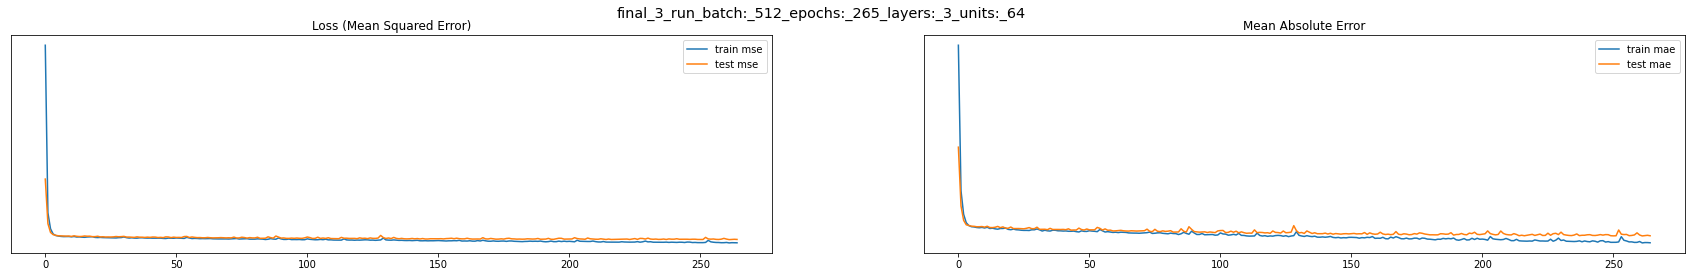

                                                type  mean_squared_error  \
0  train:_final_3_run_batch:_512_epochs:_265_laye...              11.526   
1  test:_final_3_run_batch:_512_epochs:_265_layer...              14.807   
2  final_3_run_batch:_512_epochs:_265_layers:_3_u...               3.281   

   mean_absolute_error  r2_score  e_v_score  
0                2.487    96.031     96.055  
1                2.846    94.949     94.973  
2                0.360     1.082      1.082  

Epoch 1: val_loss improved from inf to 0.06640, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_4_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 2: val_loss improved from 0.06640 to 0.03817, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final_4_run_batch:_512_epochs:_265_layers:_3_units:_64.hdf5

Epoch 3: val_loss improved from 0.03817 to 0.02829, saving model to /content

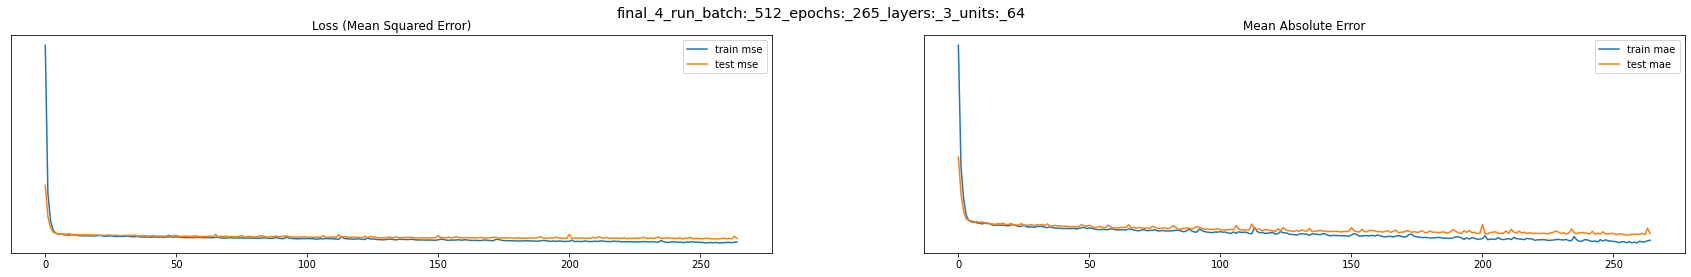

                                                type  mean_squared_error  \
0  train:_final_4_run_batch:_512_epochs:_265_laye...              11.602   
1  test:_final_4_run_batch:_512_epochs:_265_layer...              14.816   
2  final_4_run_batch:_512_epochs:_265_layers:_3_u...               3.214   

   mean_absolute_error  r2_score  e_v_score  
0                2.527    96.005     96.055  
1                2.852    94.946     94.998  
2                0.325     1.059      1.057  


In [ ]:
train = DataFrame()
val = DataFrame()
mae = DataFrame()
val_mae = DataFrame()
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
for i in range(5):
  hist = complete_run(f"final_{i}_run_batch:_512_epochs:_265_layers:_3_units:_64",pipe,ep = 265,pat = 500,  n_layers = 3, unt = 64, batch = 512)  
  train[str(i)] = hist[0].history['loss']
  val[str(i)]=hist[0].history['val_loss']
  mae[str(i)]= hist[0].history['mae']
  val_mae[str(i)] = hist[0].history['val_mae']

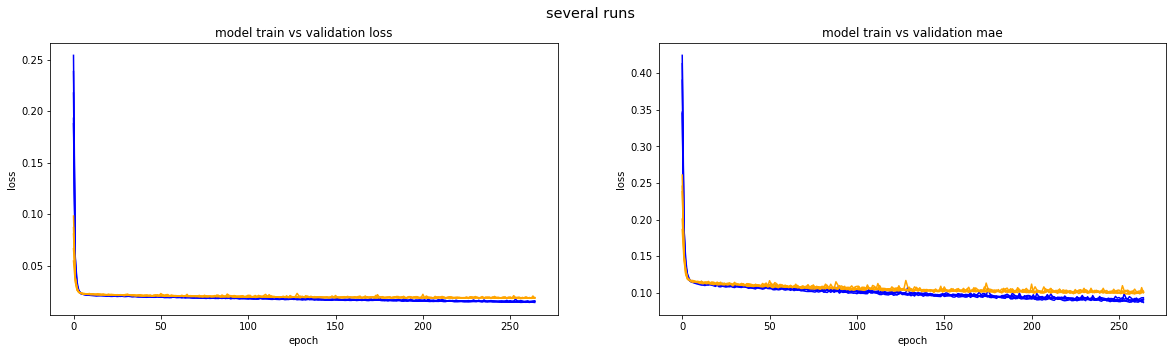

In [ ]:
f = plt.figure(figsize=(20,5))
st = f.suptitle('several runs', fontsize="x-large")

plt.subplot(1,2,1)
plt.title('loss')
plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot (1,2,2)
plt.plot(mae, color='blue', label='train')
plt.plot(val_mae, color='orange', label='validation')
plt.title('model train vs validation mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
  
plt.show()

,modelName,train_mse,test_mse,difference
0,final_0_run_batch:_512_epochs:_265_layers:_3_units:_64,11.396,14.807,3.411
3,final_3_run_batch:_512_epochs:_265_layers:_3_units:_64,11.526,14.807,3.281
4,final_4_run_batch:_512_epochs:_265_layers:_3_units:_64,11.602,14.816,3.214
1,final_1_run_batch:_512_epochs:_265_layers:_3_units:_64,12.232,15.096,2.864
2,final_2_run_batch:_512_epochs:_265_layers:_3_units:_64,11.479,15.104,3.625
,modelName,train_mae,test_mae,difference
3,final_3_run_batch:_512_epochs:_265_layers:_3_units:_64,2.487,2.846,0.360
0,final_0_run_batch:_512_epochs:_265_layers:_3_units:_64,2.498,2.851,0.354
4,final_4_run_batch:_512_epochs:_265_layers:_3_units:_64,2.527,2.852,0.325
2,final_2_run_batch:_512_epochs:_265_layers:_3_units:_64,2.504,2.880,0.375


<Figure size 2880x1080 with 0 Axes>

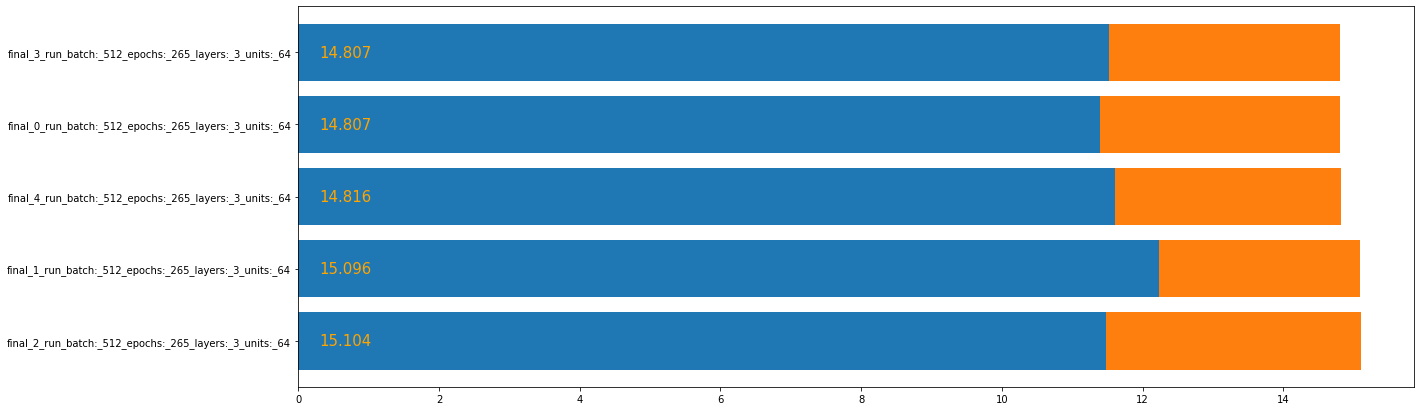

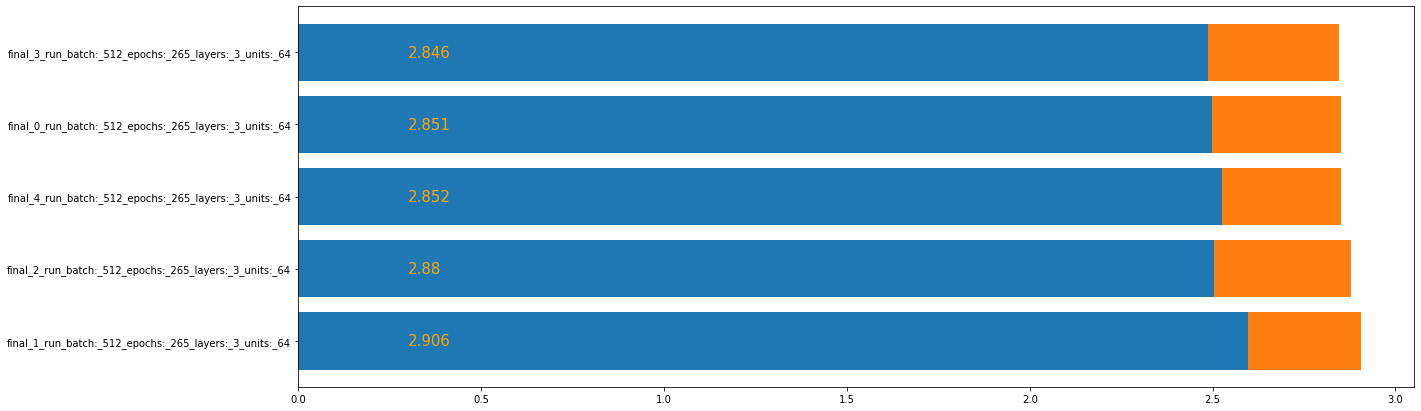

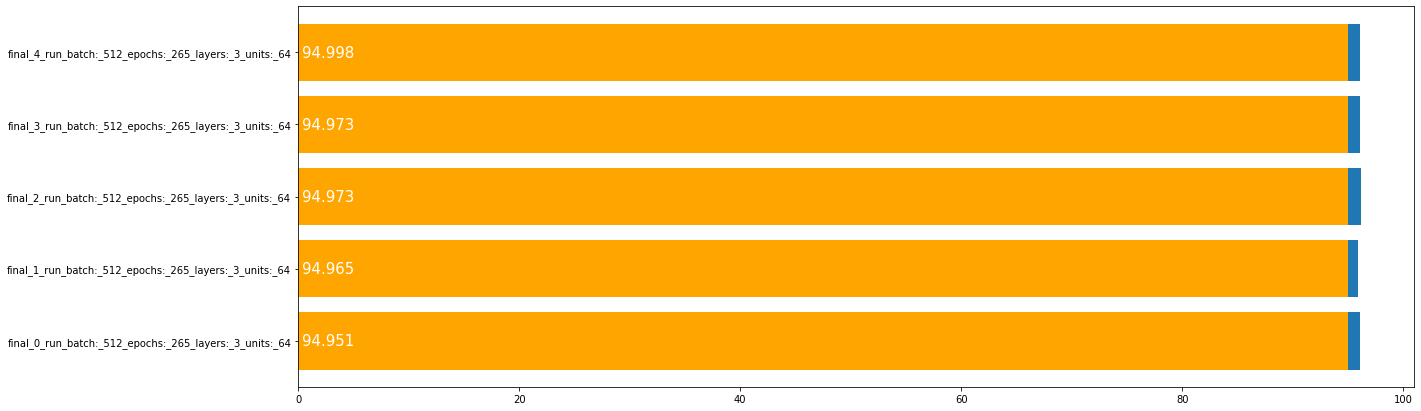

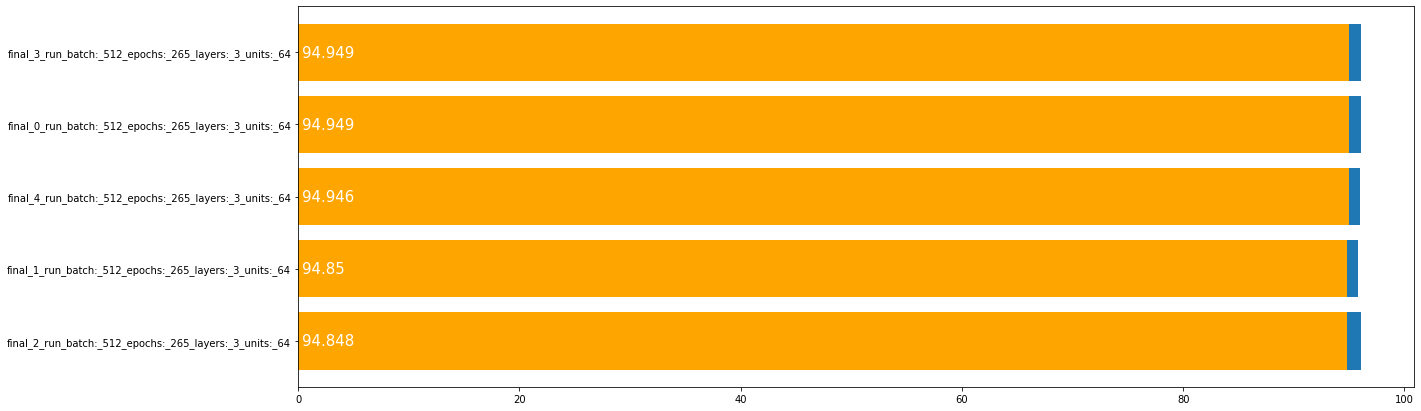

In [ ]:
show_results()

## model 2


Epoch 1: val_loss improved from inf to 0.13627, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_0_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.13627 to 0.05192, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_0_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.05192 to 0.03471, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_0_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 4: val_loss improved from 0.03471 to 0.02843, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_0_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 5: val_loss improved from 0.02843 to 0.02577, saving model to /content/drive/

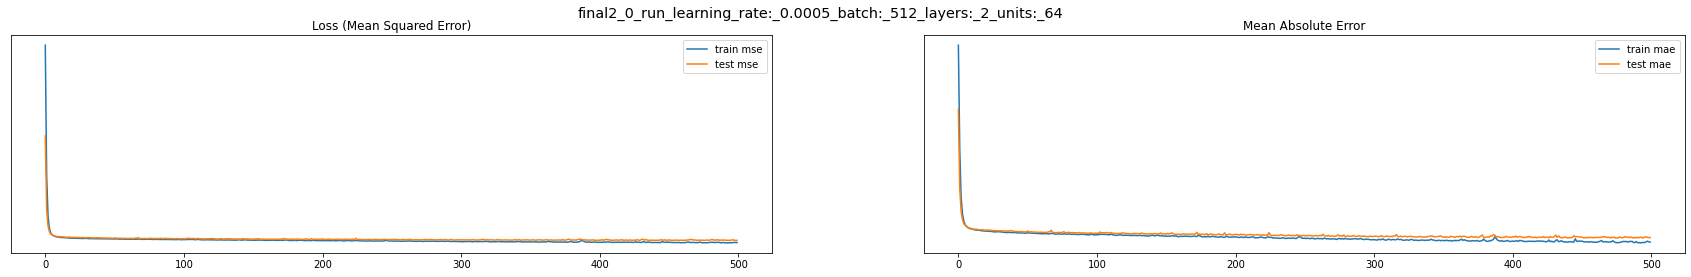

                                                type  mean_squared_error  \
0  train:_final2_0_run_learning_rate:_0.0005_batc...              12.719   
1  test:_final2_0_run_learning_rate:_0.0005_batch...              15.086   
2  final2_0_run_learning_rate:_0.0005_batch:_512_...               2.368   

   mean_absolute_error  r2_score  e_v_score  
0                2.663    95.621     95.630  
1                2.900    94.854     94.861  
2                0.238     0.767      0.769  

Epoch 1: val_loss improved from inf to 0.15029, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_1_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.15029 to 0.05513, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_1_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.05513 to 0.03502, sa

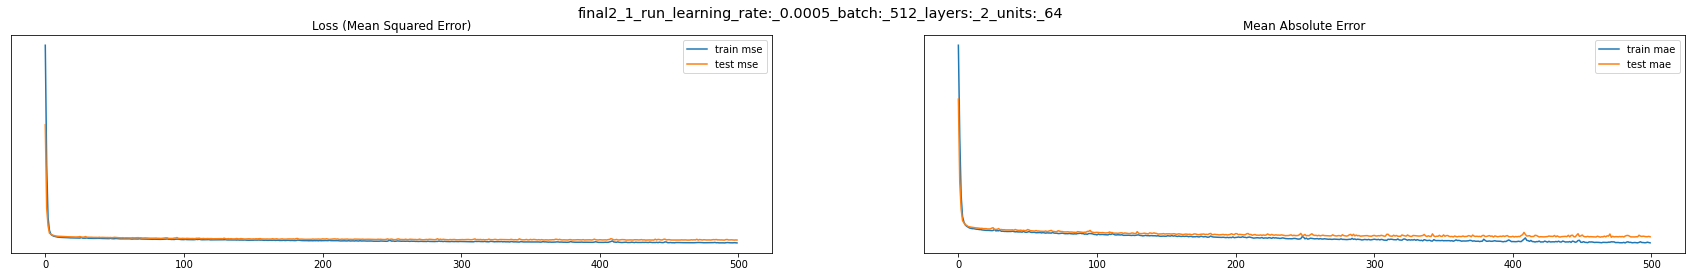

                                                type  mean_squared_error  \
0  train:_final2_1_run_learning_rate:_0.0005_batc...              12.380   
1  test:_final2_1_run_learning_rate:_0.0005_batch...              15.038   
2  final2_1_run_learning_rate:_0.0005_batch:_512_...               2.658   

   mean_absolute_error  r2_score  e_v_score  
0                2.606    95.737     95.778  
1                2.894    94.871     94.908  
2                0.288     0.866      0.870  

Epoch 1: val_loss improved from inf to 0.23773, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_2_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.23773 to 0.11236, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_2_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.11236 to 0.05154, sa

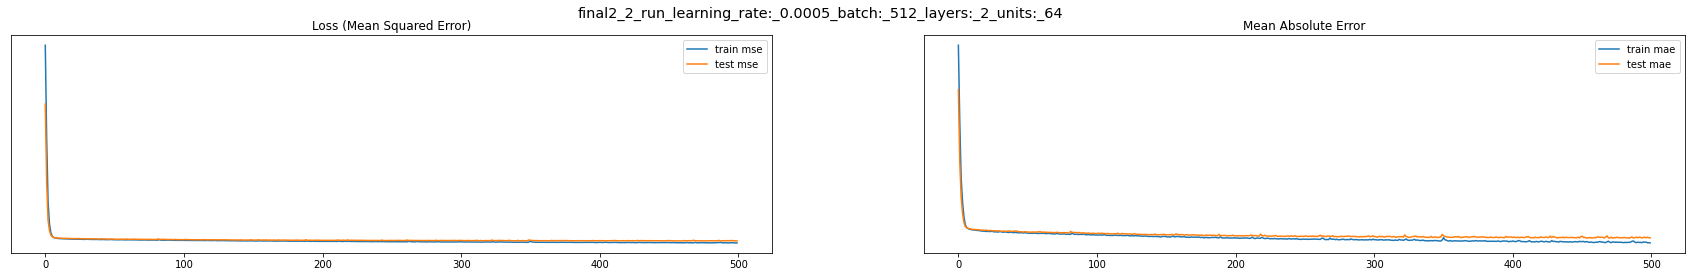

                                                type  mean_squared_error  \
0  train:_final2_2_run_learning_rate:_0.0005_batc...              11.906   
1  test:_final2_2_run_learning_rate:_0.0005_batch...              14.583   
2  final2_2_run_learning_rate:_0.0005_batch:_512_...               2.678   

   mean_absolute_error  r2_score  e_v_score  
0                2.555    95.901     95.918  
1                2.825    95.025     95.040  
2                0.270     0.876      0.878  

Epoch 1: val_loss improved from inf to 0.15084, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_3_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.15084 to 0.05817, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_3_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.05817 to 0.03880, sa

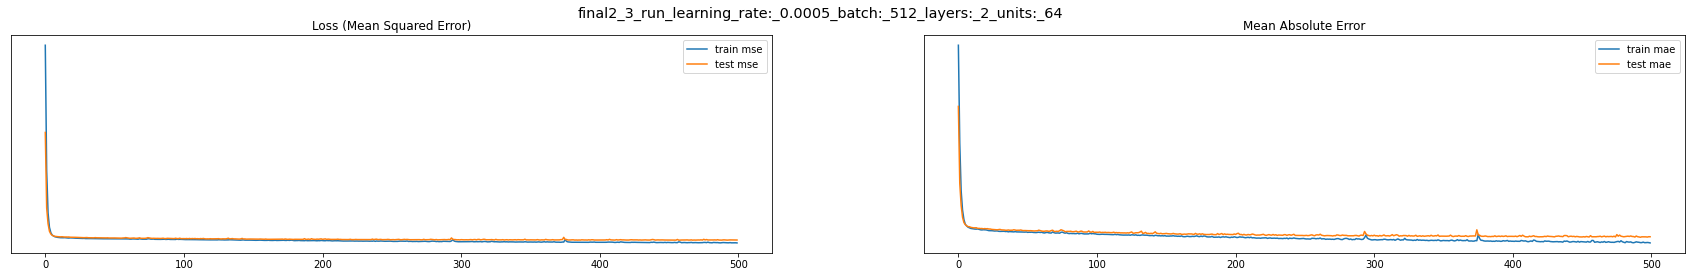

                                                type  mean_squared_error  \
0  train:_final2_3_run_learning_rate:_0.0005_batc...              12.249   
1  test:_final2_3_run_learning_rate:_0.0005_batch...              15.142   
2  final2_3_run_learning_rate:_0.0005_batch:_512_...               2.894   

   mean_absolute_error  r2_score  e_v_score  
0                2.591    95.782     95.787  
1                2.885    94.835     94.841  
2                0.295     0.947      0.946  

Epoch 1: val_loss improved from inf to 0.16012, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_4_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.16012 to 0.06125, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_final2_4_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.06125 to 0.03496, sa

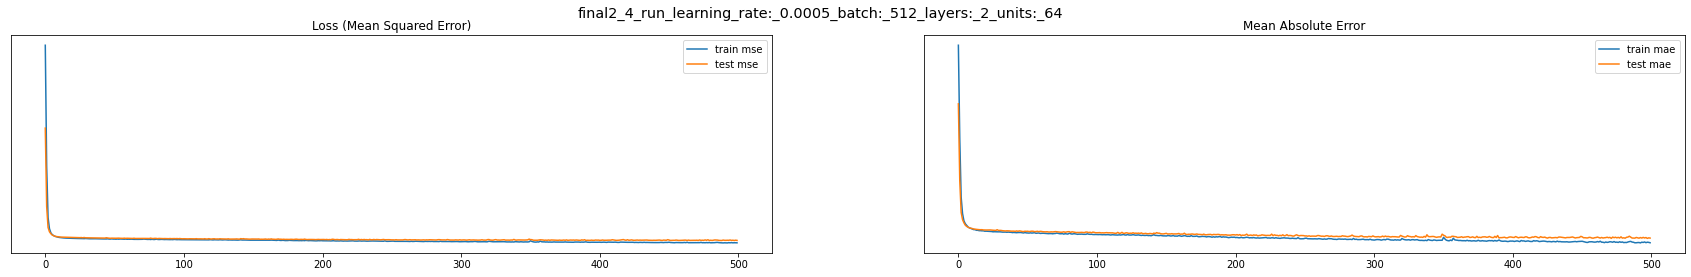

                                                type  mean_squared_error  \
0  train:_final2_4_run_learning_rate:_0.0005_batc...              12.445   
1  test:_final2_4_run_learning_rate:_0.0005_batch...              15.052   
2  final2_4_run_learning_rate:_0.0005_batch:_512_...               2.607   

   mean_absolute_error  r2_score  e_v_score  
0                2.630    95.715     95.756  
1                2.864    94.866     94.900  
2                0.234     0.849      0.856  


In [ ]:
train = DataFrame()
val = DataFrame()
mae = DataFrame()
val_mae = DataFrame()
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
for i in range(5):
  optimizer = keras.optimizers.Adam(learning_rate=0.0005)
  hist = complete_run(f"final2_{i}_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64",pipe,ep =  500,pat = 500, opt = optimizer, n_layers = 2, unt = 64, batch = 512)  
  train[str(i)] = hist[0].history['loss']
  val[str(i)]=hist[0].history['val_loss']
  mae[str(i)]= hist[0].history['mae']
  val_mae[str(i)] = hist[0].history['val_mae']

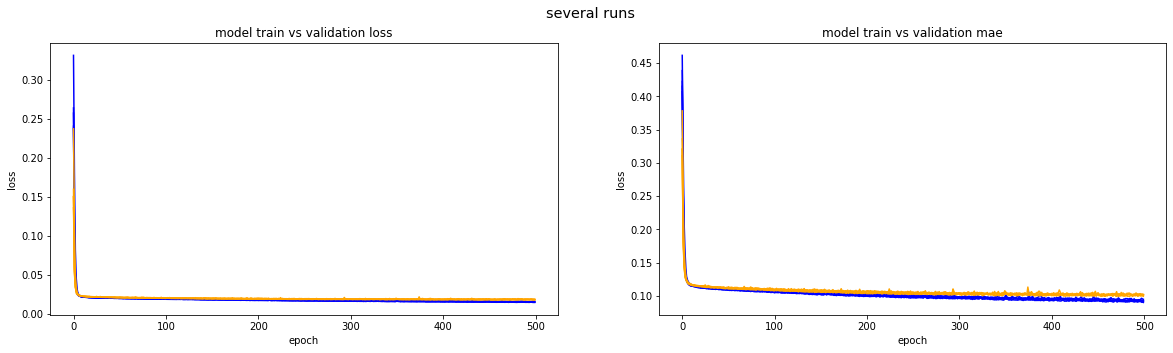

In [ ]:
f = plt.figure(figsize=(20,5))
st = f.suptitle('several runs', fontsize="x-large")

plt.subplot(1,2,1)
plt.title('loss')
plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot (1,2,2)
plt.plot(mae, color='blue', label='train')
plt.plot(val_mae, color='orange', label='validation')
plt.title('model train vs validation mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
  
plt.show()

In [ ]:
show_results(False)

,modelName,train_mse,test_mse,difference
8,final2_2_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,11.906,14.583,2.678
1,final_0_run_batch:_256_epochs:_250_layers:_2_units:_64,11.303,14.640,3.338
4,final_3_run_batch:_256_epochs:_250_layers:_2_units:_64,11.334,14.793,3.459
2,final_1_run_batch:_256_epochs:_250_layers:_2_units:_64,11.739,14.818,3.079
3,final_2_run_batch:_256_epochs:_250_layers:_2_units:_64,11.346,14.967,3.621
0,final_batch:_256_epochs:_250_layers:_2_units:_64,11.214,15.014,3.800
7,final2_1_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,12.380,15.038,2.658
5,final_4_run_batch:_256_epochs:_250_layers:_2_units:_64,11.316,15.047,3.732
10,final2_4_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,12.445,15.052,2.607
6,final2_0_run_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,12.719,15.086,2.368


<Figure size 2880x1080 with 0 Axes>

As it can be seen after several runs second model with learning rate 0.0005 overfits less and mse difference stayes within 3.

#Conclusion

**Data Preparation:**

  In current part of the project data preparation was performed via pipelines. 
  Both features RH and AP has outliers and need to be transformed. 
  The combination of both RH and AP features wisorized and only AP feature
  transformed via rcpr transformer has shown optimal results.

**Model training and hyper parameters tuning:**

  Model with adam optimizer has shown optimal results. Further on parameters
  such as
*   patience tuning
*   batch size
*   units
*   learning rate
  were tuned to achieve optimal result.

Among all models two models with standard learning rate 0.001 and mith tuned learning rate 0.0005 has shown best results. But after several runs the model with tuned learning rate 0.0005 has shown more stable and expected results where difference in mse will be less than <3

**Overall the results in comparison to ann basemodel improved:**

*   mse from 18.7 to 14.7
*   mae from 3.3 to 3.8
*   r2score from 93.6 to 94.9
*   evs from 93.6 to 94.9







,modelName,train_mse,test_mse,difference
2,final_version_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,12.156,14.742,2.586
1,base_ann,17.774,18.720,0.947
0,basemodel,21.448,22.164,0.716
,modelName,train_mae,test_mae,difference
2,final_version_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,2.572,2.833,0.261
1,base_ann,3.253,3.296,0.043
0,basemodel,3.659,3.687,0.028
,modelName,train_r2score,test_r2score,difference
2,final_version_learning_rate:_0.0005_batch:_512_layers:_2_units:_64,95.814,94.971,0.843
1,base_ann,93.880,93.614,0.266


<Figure size 2880x1080 with 0 Axes>

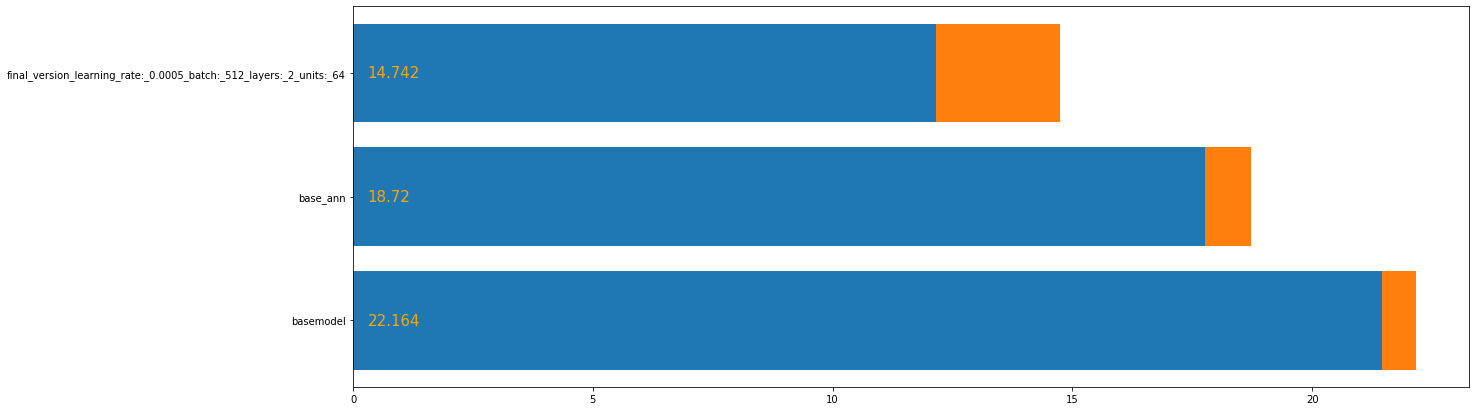

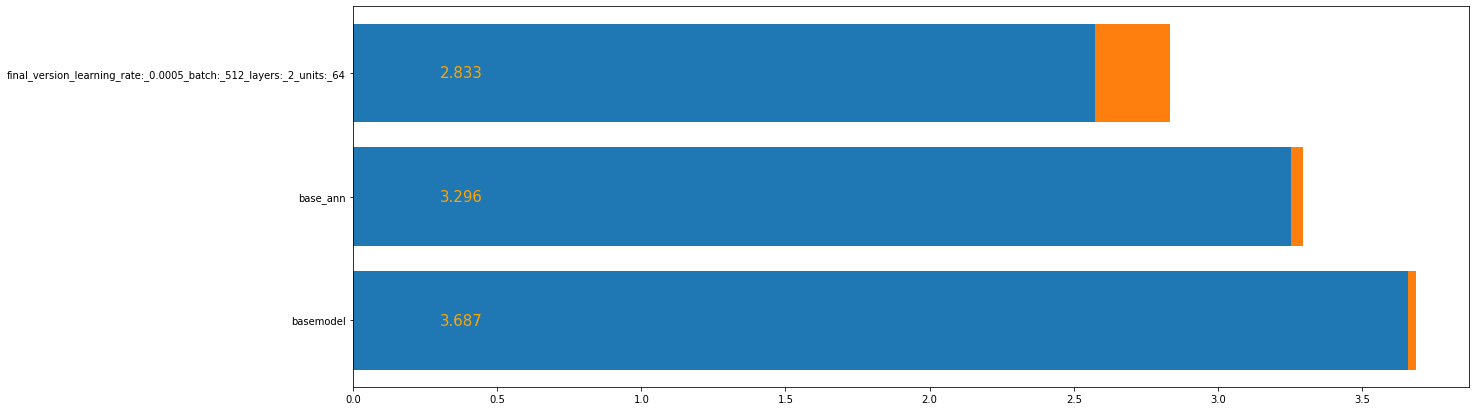

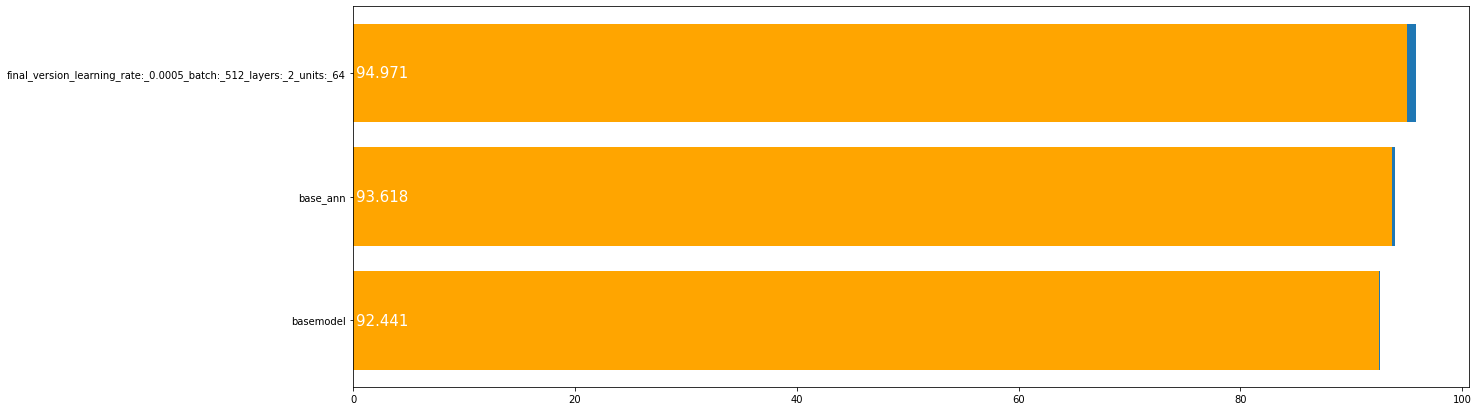

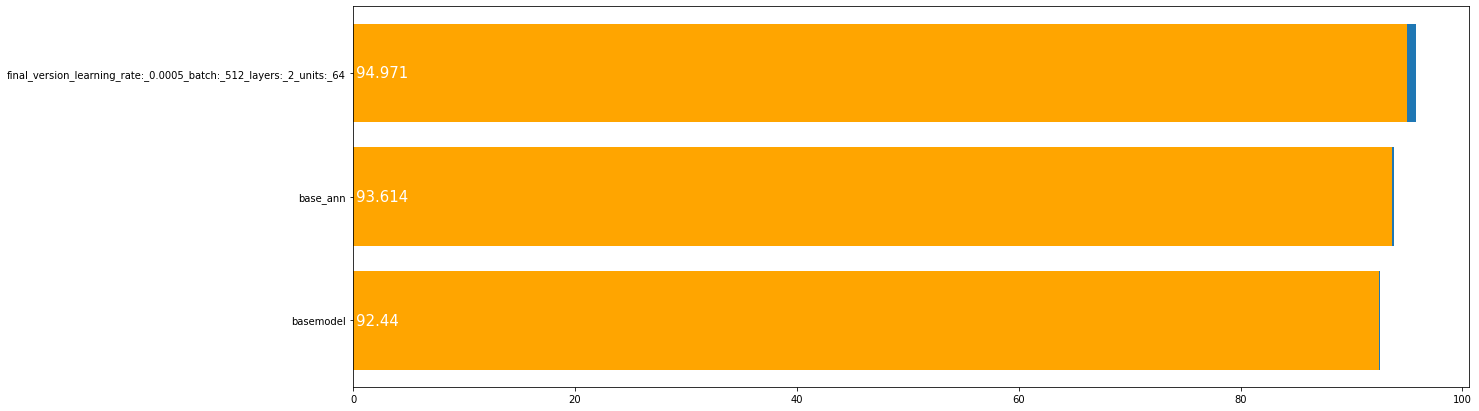

In [ ]:
show_results()